# **Import Necessary Libraries**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout

# **Setup Kaggle API to Download Dataset**

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c customer-churn-prediction-2020

100% 154k/154k [00:00<00:00, 365kB/s]
100% 154k/154k [00:00<00:00, 365kB/s]


# **Extract the Dataset**

In [4]:
from zipfile import ZipFile
file_name = '/content/customer-churn-prediction-2020.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('file extracted')

file extracted


In [5]:
!ls

customer-churn-prediction-2020.zip  sample_data		  test.csv
kaggle.json			    sampleSubmission.csv  train.csv


# **Load Train and Test Data**

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
train_df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [9]:
train_df.isnull().sum()

,0
state,0
account_length,0
area_code,0
international_plan,0
voice_mail_plan,0
number_vmail_messages,0
total_day_minutes,0
total_day_calls,0
total_day_charge,0
total_eve_minutes,0


# **Encode Categorical Variables**

In [10]:
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

# **Align Test Data with Training Columns**

In [11]:
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

In [12]:
test_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes,churn_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,False,False,False,False,False,True,False,False,True,0
1,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,...,False,False,False,False,False,False,True,True,False,0
2,62,0,120.7,70,20.52,307.2,76,26.11,203.0,99,...,False,False,False,False,False,True,False,False,False,0
3,93,0,190.7,114,32.42,218.2,111,18.55,129.6,121,...,True,False,False,False,False,False,True,False,False,0
4,174,0,124.3,76,21.13,277.1,112,23.55,250.7,115,...,False,False,False,False,False,True,False,False,False,0



# **Split Features and Target Variable**

In [13]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['churn_yes'], axis=1)
Y = train_df['churn_yes']

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 3)

In [15]:
print(X_train.shape, X_test.shape, Y_test.shape, Y_train.shape)

(3400, 69) (850, 69) (850,) (3400,)


# **Standardize Features**

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# **Define the Neural Network Model**

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (69,)),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation = 'sigmoid')
])

from tensorflow.keras import regularizers
model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Compile the Model**

In [22]:
model.compile( optimizer = 'Nadam',
              loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy'])

# **Handle Imbalanced Dataset with SMOTE**

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_res, Y_train_res = smote.fit_resample(X_train_std, Y_train)

In [24]:
print("Before SMOTE:", Y_train.value_counts())
print("After SMOTE:", pd.Series(Y_train_res).value_counts())

Before SMOTE: churn_yes
False    2907
True      493
Name: count, dtype: int64
After SMOTE: churn_yes
False    2907
True     2907
Name: count, dtype: int64


# **Train the Model with Class Weights**

In [25]:
class_weights = {0: 1, 1: 10}
history = model.fit(X_train_res, Y_train_res, validation_split=0.3, epochs = 75)

Epoch 1/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3558 - loss: 4.0748 - val_accuracy: 0.0000e+00 - val_loss: 1.1591
Epoch 2/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7262 - loss: 0.6088 - val_accuracy: 0.0000e+00 - val_loss: 1.1827
Epoch 3/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7129 - loss: 0.6122 - val_accuracy: 0.0000e+00 - val_loss: 1.2121
Epoch 4/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7172 - loss: 0.5954 - val_accuracy: 0.0000e+00 - val_loss: 1.2103
Epoch 5/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7170 - loss: 0.5773 - val_accuracy: 0.0000e+00 - val_loss: 1.0908
Epoch 6/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7147 - loss: 0.5506 - val_accuracy: 0.0573 - val_loss: 0.9912
Epoch 7/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7660 - loss: 0.5147 - val_accuracy: 0.6441 - val_loss: 0.7285
Epoch 8/75
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7836 - loss: 0.45

# **Evaluate the Model on Test Data**

In [26]:
loss, accuracy  = model.evaluate(X_test_std, Y_test)
print(loss)
print(accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8889 - loss: 0.4624
0.43914198875427246
0.8917647004127502


# **Visualize Training History**

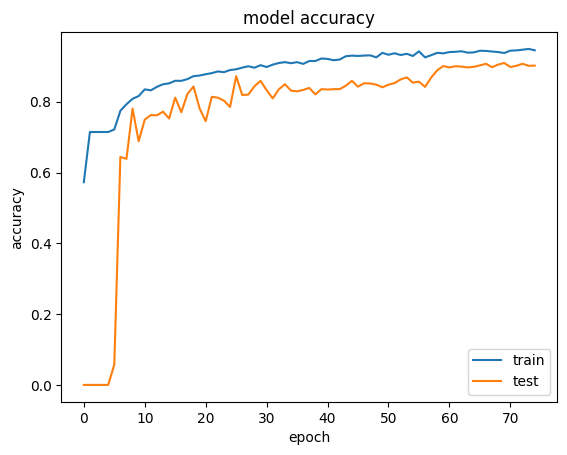

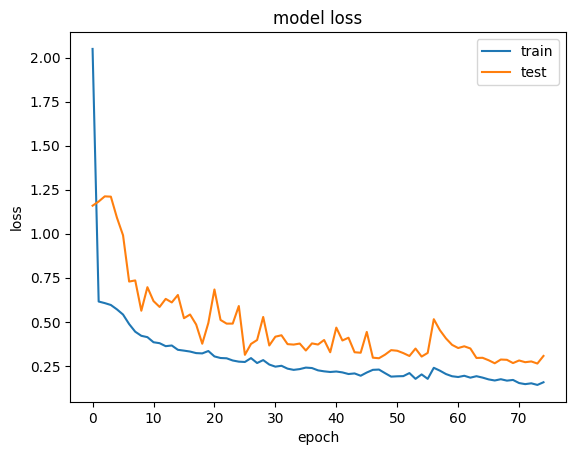

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# **Generate Classification Report and Confusion Matrix**

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
classification report:               precision    recall  f1-score   support

       False       0.89      1.00      0.94       745
        True       0.93      0.12      0.22       105

    accuracy                           0.89       850
   macro avg       0.91      0.56      0.58       850
weighted avg       0.89      0.89      0.85       850



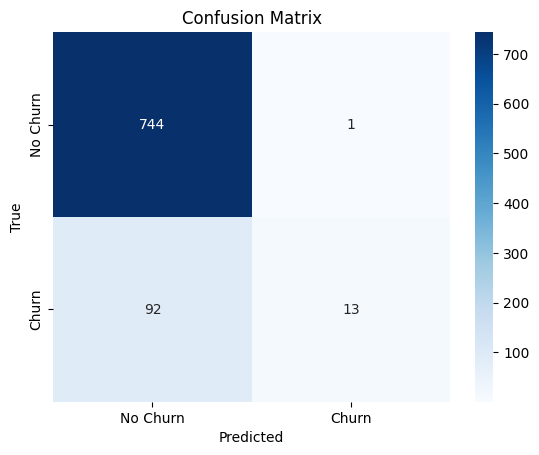

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_prob = model.predict(X_test_std)[:, 1]  # Probabilities for the "Churn" class

# Set a custom threshold
threshold = 0.4  # Adjust this value as needed

# Convert probabilities to binary predictions based on the threshold
y_pred_custom = (y_pred_prob >= threshold).astype(int)

# Print classification report
print(f"classification report: {classification_report(Y_test, y_pred_custom)}")

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **Feature Importance Using Random Forest**

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest model
rf = RandomForestClassifier()
rf.fit(X_train_std, Y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by importance
print(feature_importance.sort_values(by='Importance', ascending=False))


                          Feature  Importance
4                total_day_charge    0.136990
2               total_day_minutes    0.136339
14  number_customer_service_calls    0.108091
67         international_plan_yes    0.066372
7                total_eve_charge    0.055912
..                            ...         ...
53                       state_RI    0.000890
24                       state_GA    0.000874
60                       state_VT    0.000822
23                       state_FL    0.000815
25                       state_HI    0.000643

[69 rows x 2 columns]


# **Save the Model and Scaler**

In [31]:
import joblib

# Save the model
joblib.dump(model, 'churn_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']